In [71]:
import seaborn as sns
import pandas as pd 
import datetime as datetime
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
import json
from scipy.stats import spearmanr


import h5py




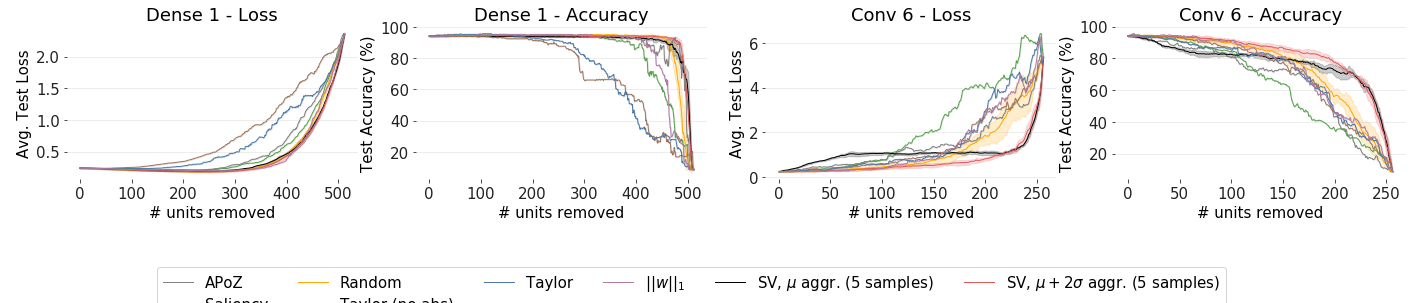

In [107]:
import scipy
f = h5py.File('comparison.hdf5', 'r')
experiment = "cifar10__random_s:1.0_steps:0_start:1_int:1_load:last"
all_data = f[experiment]

COLORS = ["orange",
          "#4e79a7",
          "#59a14f",
          "#9c755f",
          "#666666",
          "#e15759",
          "#b07aa1",
          "#BEAD53",
          "grey"]

map_names = {

    "sv-loss-2std#5": ("SV, $\mu+2\sigma$ aggr. (5 samples)", COLORS[5]),
    "random": ("Random", COLORS[0]),
    "grad": ("Saliency",COLORS[2]),
    "taylor-abs": ("Taylor",COLORS[1]),
    "count": ("APoZ",COLORS[8]),
    "weight": ("$||w||_1$",COLORS[6]),
    
    # Additional
      "taylor": ("Taylor (no abs)",COLORS[3]),
#     "sv-loss-final-p2#25": ("SV Classic (10 samples)",COLORS[3]),
#     "sv-loss-99p#5": ("SV", "blue"),
     "sv-loss#10": ("SV, $\mu$ aggr. (5 samples)", "black"),
}

def format_plt(ax, title, xlabel, ylabel):
    plt.sca(ax)
    plt.box(False)
    plt.tick_params(color="#222222", labelcolor="#222222")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    if title is not None:
        plt.title(title)

plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams.update({'font.size': 15})

AUC = {}
N = 0
plot = {}
for layer_name in all_data:
    layer_data = all_data[layer_name + "/0/"]
    N += len(list(layer_data.items())[0][1]["scores"])
    if layer_name not in plot:
        plot[layer_name] = {}
    
    # Aggregate data for all methods and store
    for full_method_name, d in layer_data.items():
        method_name, iteration = full_method_name.split("--") if "--" in full_method_name else (full_method_name, 0)
        if method_name not in map_names:
            continue
        
        if method_name not in plot[layer_name]:
            plot[layer_name][method_name] = {"acc" : [], "loss": [], "scores" : []}
        
        plot[layer_name][method_name]["acc"].append(100*d["acc_test"][:])
        plot[layer_name][method_name]["loss"].append(d["loss_test"][:])
        plot[layer_name][method_name]["scores"].append(d["scores"][:])
    
#     plt.figure()
#     for method_name in ["sv-loss-2std#5", "weight", "taylor-abs"]:
#         sv_scores = plot[layer_name][method_name]["scores"][0]
#         sv_scores = np.sort(sv_scores) / np.max(np.abs(sv_scores)) * 5
#         plt.plot(range(len(sv_scores)), sv_scores, label=method_name)
#     plt.title(layer_name)
#     plt.hlines(0.1, 0, len(sv_scores))
#     plt.legend()
#     plt.ylim([0, ])
        
    # Compute AUC for each method
    # print (layer_name)
    for method_name, d in plot[layer_name].items():
        auc = np.sum(np.array(d["loss"]) - np.array(d["loss"])[:, 0][:, None], 1)
        # print (f"{method_name}: {auc}")
        if method_name not in AUC:
             AUC[method_name] = auc
        else:
            AUC[method_name] += auc


    
# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,4.0))
PLOT_LAYERS = {
    "classifier.1" : "Dense 1",
    "features.12" : "Conv 6"
}

for layer_name in PLOT_LAYERS:
    plot_data = plot[layer_name]
    
    for method_name, d in plot_data.items(): 
        label, color = map_names[method_name]
        ticks = range(len(d["loss"][0]))
        loss_mean = np.mean(d["loss"], 0)
        loss_std = np.std(d["loss"], 0)
        acc_mean = np.mean(d["acc"], 0)
        acc_std = np.std(d["acc"], 0)
        scores = np.mean(np.sort(d["scores"], 1), 0)
        scores = scores / np.sum(scores) * loss_mean[-1]
        

        if "classifier" in layer_name:
            ax_loss, ax_acc = ax1, ax2
        else:
            ax_loss, ax_acc = ax3, ax4

        ax_loss.fill_between(ticks, loss_mean + loss_std, loss_mean - loss_std, alpha=.2, color=color)
        ax_loss.plot(ticks, loss_mean, label=label, color=color, lw=1)
        format_plt(ax_loss, f"{PLOT_LAYERS[layer_name]} - Loss", "# units removed", "Avg. Test Loss")

        ax_acc.fill_between(ticks, acc_mean + acc_std, acc_mean - acc_std, alpha=.2, color=color)
        ax_acc.plot(ticks, acc_mean, label=label, color=color, lw=1)
        format_plt(ax_acc, f"{PLOT_LAYERS[layer_name]} - Accuracy", "# units removed", "Test Accuracy (%)")
        

handles, labels = ax_loss.get_legend_handles_labels()
handles, labels  = zip(*sorted(zip(handles, labels), key=lambda t: 1 if "SV" in t[1] else -1))
fig.subplots_adjust(bottom=.35)
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.40, 0.15), ncol=6)
plt.savefig(f"cifar10_ablation_study.pdf", bbox_inches='tight')


In [158]:
# Convergence of Shapley values

import scipy
f = h5py.File('sv.hdf5', 'r')
experiment = "cifar10__sv-loss-2std#20_s:0.22_steps:16_start:0_int:1_load:last/"
all_data = f[experiment]

deltas = np.zeros((len(all_data), 10))
for j, layer_name in enumerate(all_data):
    d = np.array(all_data[layer_name][0]["sv"])
    current = np.zeros((d.shape[2],))
    
    for i in range(d.shape[1]):
        delta = np.mean((current - d[:, :i, :].mean(0).mean(0))**2)
        deltas[j, i] = delta
        current = d[:, :i, :].mean(0).mean(0)

plt.figure()
plt.plot(range(len(deltas.mean(0))), deltas.mean(0))



TypeError: string indices must be integers

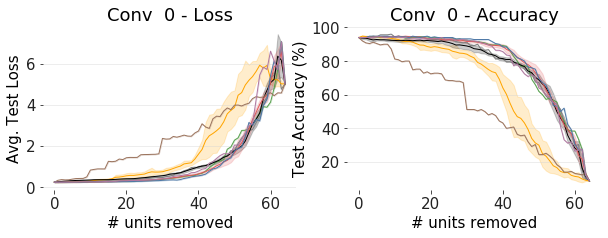

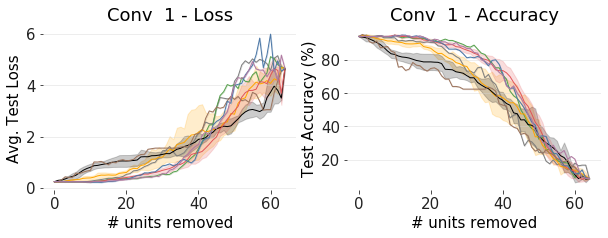

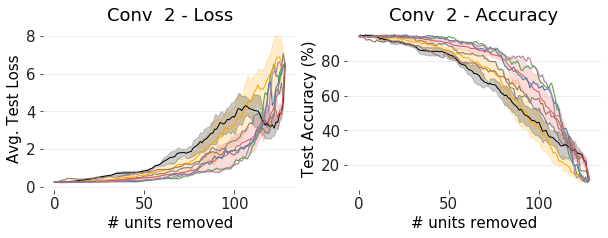

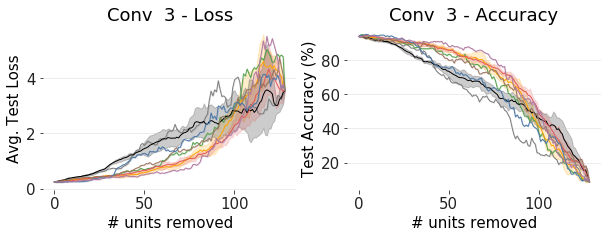

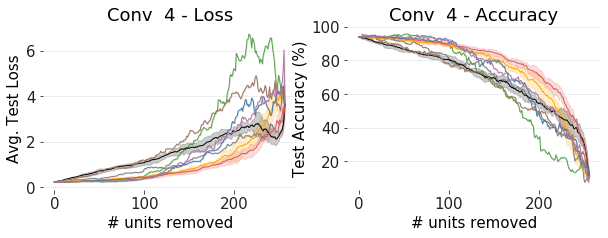

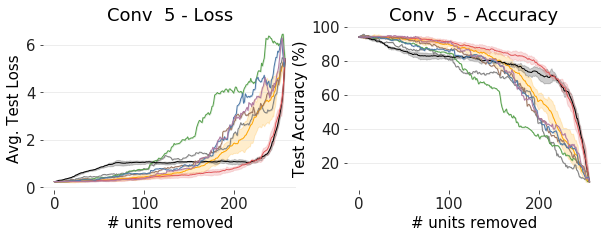

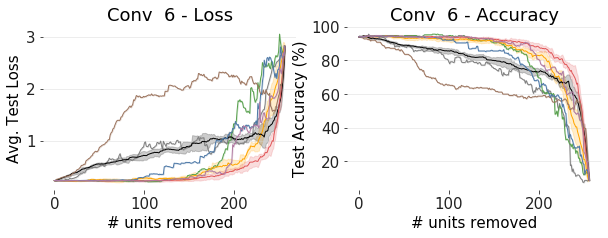

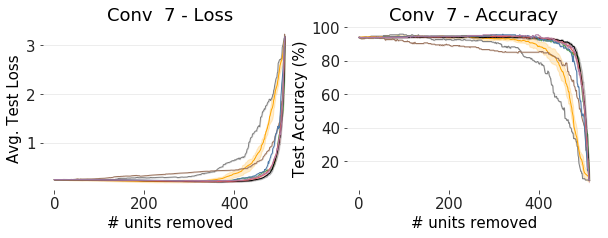

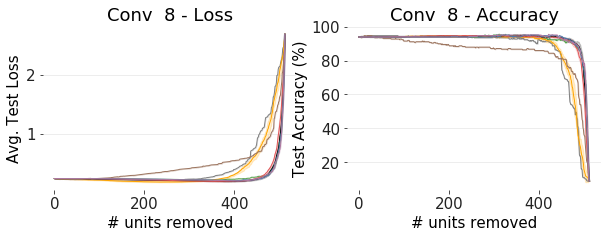

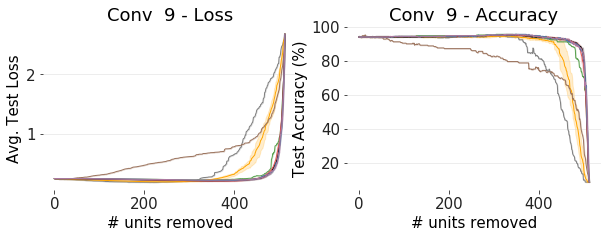

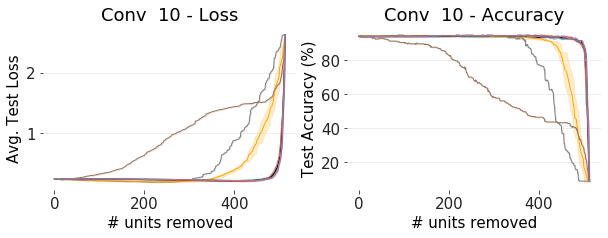

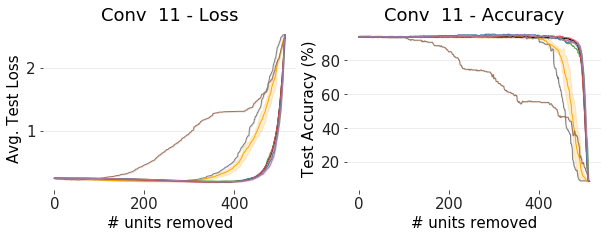

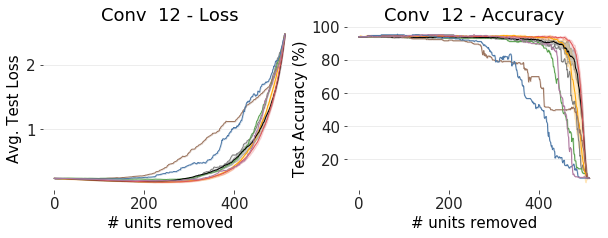

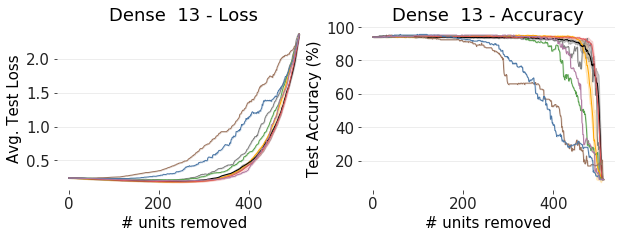

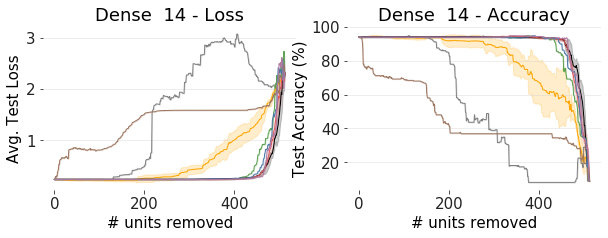

<Figure size 432x288 with 0 Axes>

In [120]:
layers = plot.keys()
layers = sorted(layers, key=lambda x: -int(x.split(".")[1]), reverse=True)
layers = sorted(layers, key=lambda x: 0 if "classifier" in x else 1, reverse=True)

for idx, layer_name in enumerate(layers):
    plot_data = plot[layer_name]
    layer_name_norm = f"{'Conv ' if 'features' in layer_name else 'Dense '} {idx}"
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.0))
    
    for method_name, d in plot_data.items(): 
        label, color = map_names[method_name]
        ticks = range(len(d["loss"][0]))
        loss_mean = np.mean(d["loss"], 0)
        loss_std = np.std(d["loss"], 0)
        acc_mean = np.mean(d["acc"], 0)
        acc_std = np.std(d["acc"], 0)
        scores = np.mean(np.sort(d["scores"], 1), 0)
        scores = scores / np.sum(scores) * loss_mean[-1]
        
        ax_loss, ax_acc = ax1, ax2

        ax_loss.fill_between(ticks, loss_mean + loss_std, loss_mean - loss_std, alpha=.2, color=color)
        ax_loss.plot(ticks, loss_mean, label=label, color=color, lw=1)
        format_plt(ax_loss, f"{layer_name_norm} - Loss", "# units removed", "Avg. Test Loss")

        ax_acc.fill_between(ticks, acc_mean + acc_std, acc_mean - acc_std, alpha=.2, color=color)
        ax_acc.plot(ticks, acc_mean, label=label, color=color, lw=1)
        format_plt(ax_acc, f"{layer_name_norm} - Accuracy", "# units removed", "Test Accuracy (%)")
    plt.savefig(f"cifar10_ablation_study_{layer_name_norm.replace(' ', '')}.pdf", bbox_inches='tight')
        

handles, labels = ax_loss.get_legend_handles_labels()
handles, labels  = zip(*sorted(zip(handles, labels), key=lambda t: 1 if "SV" in t[1] else -1))
fig = plt.figure()
fig.legend(handles, labels,loc='center', ncol=4)
plt.savefig(f"cifar10_ablation_study_legend.pdf", bbox_inches='tight')


In [40]:
print ("Area under the curve (AUC)")
for method, auc in AUC.items():
    auc /= N
    auc_string = f"{auc.mean():.2f} +- {auc.std():.2f}"
    print (f"{method}\t\t\t{auc_string}")
    
f.close()

Area under the curve (AUC)
count			0.30 +- 0.00
grad			0.24 +- 0.00
random			0.29 +- 0.02
sv-loss#10			0.11 +- 0.00
sv-loss-2std#5			0.11 +- 0.00
taylor			1.04 +- 0.00
taylor-abs			0.20 +- 0.00
weight			0.19 +- 0.00


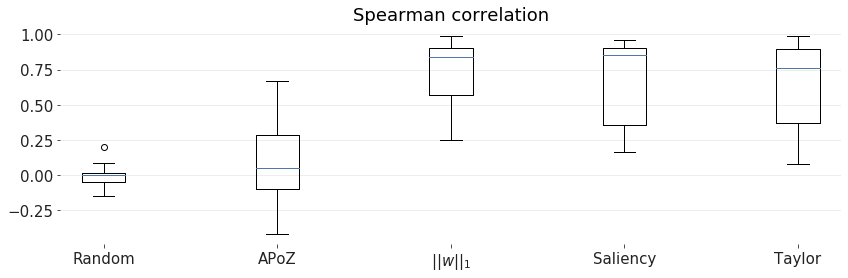

In [123]:
# Compute correlation to SV for each layer
experiments = ["cifar10__random_s:1.0_steps:0_start:1_int:1_load:last"]
mt = ["random", "count", "weight", "grad", "taylor-abs"]
plt.figure(figsize=(14,4.0))

for idx, exp in enumerate(experiments):
    f = h5py.File('comparison.hdf5', 'r')
    all_data = f[exp]
    
    plot = {}
    for layer_name in all_data:
        layer_data = all_data[layer_name + "/0/"]
        N += len(list(layer_data.items())[0][1]["scores"])
        if layer_name not in plot:
            plot[layer_name] = {}
    
        # Aggregate data for all methods and store
        for full_method_name, d in layer_data.items():
            method_name, iteration = full_method_name.split("--") if "--" in full_method_name else (full_method_name, 0)
            if method_name not in map_names:
                continue

            if method_name not in plot[layer_name]:
                plot[layer_name][method_name] = {"acc" : [], "loss": [], "scores" : []}

            plot[layer_name][method_name]["acc"].append(100*d["acc_test"][:])
            plot[layer_name][method_name]["loss"].append(d["loss_test"][:])
            plot[layer_name][method_name]["scores"].append(d["scores"][:])

    correlations = {}
    for layer_name, layer_data in plot.items():
        sv_scores = None
        for method_name, d in layer_data.items():
            if method_name == "sv-loss-2std#5":
                sv_scores = np.mean(d["scores"], 0)
        for method_name, d in layer_data.items():
            scores = np.mean(d["scores"], 0)
            corr = scipy.stats.spearmanr(sv_scores, scores)
            if method_name not in correlations:
                correlations[method_name] = []
            correlations[method_name].append(corr[0])

    values, keys = [], []
    for k in mt:
        if "sv" in k:
            continue
        values.append(np.array(correlations[k]))
        keys.append(map_names[k][0])
    plt.boxplot(values, labels=keys, positions=np.array(range(len(values)))*2.0)
    format_plt(plt.gca(), f"Spearman correlation", "", "")
    plt.savefig(f"cifar10_attribution_correlation.pdf", bbox_inches='tight')


(4192,) (4192,)
(5248,) (5248,)


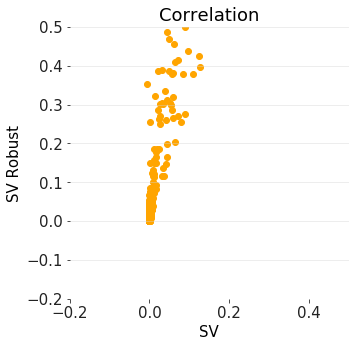

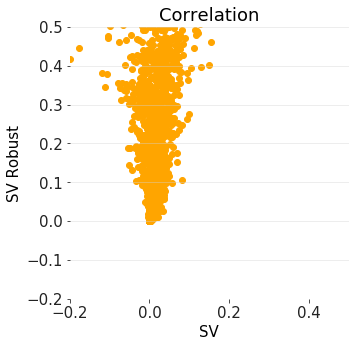

In [70]:
# Compare SV with Robust SV
experiments = ["fmnist__random_s:1.0_steps:0_start:1_int:1_load:last", "cifar10__random_s:1.0_steps:0_start:1_int:1_load:last"]
mt = ["random", "count", "weight", "grad", "taylor-abs"]

for idx, exp in enumerate(experiments):
    f = h5py.File('comparison.hdf5', 'r')
    all_data = f[exp]
    plt.figure(figsize=(5,5))
    plot = {}
    for layer_name in all_data:
        layer_data = all_data[layer_name + "/0/"]
        N += len(list(layer_data.items())[0][1]["scores"])
        if layer_name not in plot:
            plot[layer_name] = {}
    
        # Aggregate data for all methods and store
        for full_method_name, d in layer_data.items():
            method_name, iteration = full_method_name.split("--") if "--" in full_method_name else (full_method_name, 0)
            if method_name not in map_names:
                continue

            if method_name not in plot[layer_name]:
                plot[layer_name][method_name] = {"acc" : [], "loss": [], "scores" : []}

            plot[layer_name][method_name]["acc"].append(100*d["acc_test"][:])
            plot[layer_name][method_name]["loss"].append(d["loss_test"][:])
            plot[layer_name][method_name]["scores"].append(d["scores"][:])

    scores_sv = []
    scores_sv_robust = []
    for layer_name, layer_data in plot.items():
        for method_name, d in layer_data.items():
            if method_name == "sv-loss-2std#5":
                scores_sv_robust.append(np.mean(d["scores"], 0))
            elif method_name == "sv-loss#10":
                scores_sv.append(np.mean(d["scores"], 0))
    
    scores_sv = np.concatenate(scores_sv).ravel()
    scores_sv_robust = np.concatenate(scores_sv_robust).ravel()
    print (scores_sv.shape, scores_sv_robust.shape)
    plt.scatter(scores_sv, scores_sv_robust)
    plt.ylim([-.2, 0.5])
    plt.xlim([-.2, 0.5])
    format_plt(plt.gca(), f"Correlation", "SV", "SV Robust")

relu1
(1000, 5, 32)
Var 0 0.15692157
Var 1 0.09248607
(32,)
abs - std
KendalltauResult(correlation=0.4193548387096775, pvalue=0.0007434794433868002)
abs - 90p
KendalltauResult(correlation=0.37096774193548393, pvalue=0.0028466732529616556)
abs - normal
KendalltauResult(correlation=0.1370967741935484, pvalue=0.2701492944544325)
relu2
(1000, 5, 64)
Var 0 0.03513017
Var 1 0.018315153
(64,)


IndexError: index 62 is out of bounds for axis 0 with size 50

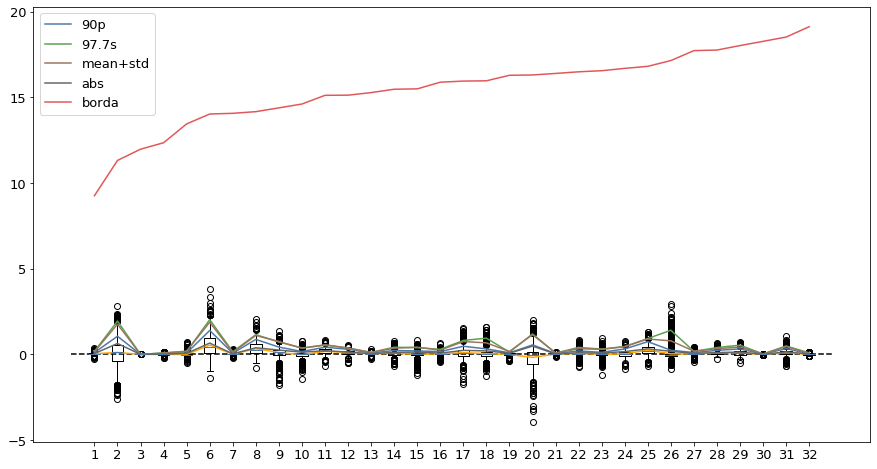

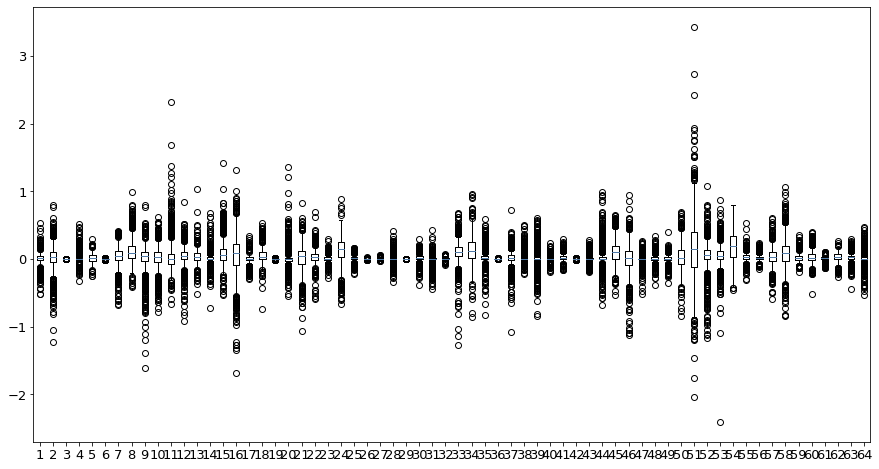

In [68]:
f = h5py.File('sv.hdf5', 'r')
experiment = "fmnist__random_s:1.0_steps:0_start:1_int:1_load:last"
all_data = f[experiment]

for layer_name in all_data:
    print (layer_name)
    sv = all_data[layer_name + "/0/sv"]
    sv = np.array(sv)    
    print (sv.shape)
    print ("Var 0", sv.var(0).mean())
    print ("Var 1", sv.var(1).mean())
    plt.figure(figsize=(15,8))
    
    actual_sv = sv.mean(1).mean(0)
    actual_sv_truncated = actual_sv[:50]
#     print ("Normal rank: ", np.argsort(actual_sv))
    sv_90p = np.percentile(sv.mean(1), 90, axis=0)
    sv_99p = np.percentile(sv.mean(1), 97.7, axis=0)
    sv_std = sv.mean(1).mean(0) + 2*sv.mean(1).std(0)
    sv_abs = np.abs(sv.mean(1)).mean(0)
    sv_borda = (sv.mean(1)).argsort(1).mean(0)
    sv_borda = sv_borda
    print (sv_borda.shape)
#     print ("Worse case robust rank: ", np.argsort(actual_sv))


    
    idx = np.argsort(sv_borda)
   

    plt.boxplot(sv.mean(1)[:,idx], showfliers=True)
    plt.plot(1+np.arange(len(actual_sv_truncated)), actual_sv_truncated[idx])
    plt.plot(1+np.arange(len(actual_sv_truncated)), sv_90p[idx], label="90p")
    plt.plot(1+np.arange(len(actual_sv_truncated)), sv_99p[idx], label="97.7s")
    plt.plot(1+np.arange(len(actual_sv_truncated)), sv_std[idx], label="mean+std")
    plt.plot(1+np.arange(len(actual_sv_truncated)), sv_abs[idx], label="abs")
    plt.plot(1+np.arange(len(actual_sv_truncated)), sv_borda[idx], label="borda")

    plt.hlines(0.0, 0, 1 + len(actual_sv_truncated), linestyle="dashed", color="black")
    plt.legend()
#     plt.ylim([np.percentile(sv.mean(1), 0.1), np.percentile(sv.mean(1), 99.9)])
    
    print ("abs - std")
    print (scipy.stats.kendalltau(np.argsort(sv_abs), np.argsort(sv_std)))
    
    print ("abs - 90p")
    print (scipy.stats.kendalltau(np.argsort(sv_abs), np.argsort(sv_90p)))
    
    print ("abs - normal")
    print (scipy.stats.kendalltau(np.argsort(sv_abs), np.argsort(actual_sv)))



f.close()

# weight
# [29  7  8 31 14 27 20  3 12 11 17 10 26 23 30  5 28  9 22  6 24 21  1 16
#   2  4 19 25 13 15 18  0]